<base target="_blank">

*This article is part of our series about how different types of data scientists build similar models differently. No human is the same and therefore also no data scientist is the same. And the circumstances under which a data challenge needs to be handled changes constantly. For these reasons, different approaches can and will be used to complete the task at hand. In our series we will explore the four different approaches of our data scientists — Meta Oric, Aki Razzi, Andy Stand, and Eqaan Librium. They are presented with the task to build a model to predict whether employees of a company — STARDATAPEPS — will look for a new job or not. Based on their distinct profiles discussed in the <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-introducing-our-data-science-rock-stars" target="_blank" rel="noopener noreferrer">first blog</a> you can already imagine that their approaches will be quite different.*

In the <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-good-model-by-default-using-xgboost" target="_blank" rel="noopener noreferrer">previous article</a> Meta Oric’s aim was to quickly create a default XGBoost and therefore she sticked with the default settings. In this article Aki Razi is going to search for a better model performance and tries to tune the hyperparameters. Before we start with discussing how she tries to do that, let me first remind you of who Aki Razzi is:

### Aki Razzi: 'Accuracy is what truly matters'
!['Aki Razzi'](https://bhciaaablob.blob.core.windows.net/featureengineeringreeks/characters/Aki%20Razzi_400px.png)

Aki has won multiple Kaggle competitions, since her models achieve the highest possible performance. Time and resources do not matter that much to her. Hail the almighty accuracy, precision and recall. She does not care whether a technique is easy to explain or not. Similarly, she is no stranger to using ensemble models to achieve the near-perfect performance as well as very convoluted feature engineering techniques.

### Using XGBoost to predict which Data Scientists are likely to change jobs

First of all, Aki imports the necessary packages, among which ‘xgboost’ enabling her to create a XGBoost:

In [ ]:
pip install xgboost

Python interpreter will be restarted.
Requirement already satisfied: xgboost in /local_disk0/.ephemeral_nfs/envs/pythonEnv-1be747c8-32bb-426c-8dac-360a45dd7183/lib/python3.8/site-packages (1.5.2)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from xgboost) (1.19.2)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from xgboost) (1.6.2)
WARNING: You are using pip version 21.0.1; however, version 22.0.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-1be747c8-32bb-426c-8dac-360a45dd7183/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [ ]:
# Importing packages and settings: 
import warnings 
warnings.filterwarnings(action= 'ignore')
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import joblib

Second, Aki loads the dataset. A bit of preparation on this data was done, as described [here](https://www.theanalyticslab.nl/no-data-scientist-is-the-same-data-to-predict-which-employees-are-likely-to-leave). The target variable ‘target’ indicates whether a data scientist in this historic dataset has left the company. All other columns in the dataset are possible predictors of whether a data scientist is likely to leave the company soon.

In [ ]:
# Loading the data:
df_prep = pd.read_csv('https://bhciaaablob.blob.core.windows.net/featurenegineeringfiles/df_prepared.csv')
df = df_prep.drop(columns=['Unnamed: 0','city', 'experience', 'enrollee_id'])  
df.head()

Out[4]:

city_development_index 
 gender 
 enrolled_university 
 education_level 
 major_discipline 
 company_size 
 company_type 
 last_new_job 
 training_hours 
 target 
 ind_relevent_experience 
 experience_num 
 city name 
 
 
 
 
 0 
 0.920 
 Male 
 no_enrollment 
 Graduate 
 STEM 
 NaN 
 NaN 
 1 
 36 
 1 
 1 
 22.0 
 Denver-Aurora-Lakewood CO (Metro) 
 
 
 1 
 0.776 
 Male 
 no_enrollment 
 Graduate 
 STEM 
 50-99 
 Pvt Ltd 
 >4 
 47 
 0 
 0 
 15.0 
 Odessa TX (Metro) 
 
 
 2 
 0.624 
 NaN 
 Full time course 
 Graduate 
 STEM 
 NaN 
 NaN 
 never 
 83 
 0 
 0 
 5.0 
 Auburn-Opelika AL (Metro) 
 
 
 3 
 0.789 
 NaN 
 NaN 
 Graduate 
 Business Degree 
 NaN 
 Pvt Ltd 
 never 
 52 
 1 
 0 
 0.0 
 Corvallis OR (Metro) 
 
 
 4 
 0.767 
 Male 
 no_enrollment 
 Masters 
 STEM 
 50-99 
 Funded Startup 
 4 
 8 
 0 
 1 
 22.0 
 Tulsa OK (Metro)

Aki’s aim is to assess if she can improve Meta’s default XGBoost by tuning the hyperparameters. To make a fair comparison she performs the same data preparation steps as Meta did. She imputes the missing values, converts the categorical variables into dummies and standardizes the numerical variables. In addition, just like Meta did, Aki also uses [pipelines](https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d) to prep the data, to train her XGBoost, and to make predictions.

In the code below Aki separates the target from the features, creates a train and test dataset, and creates the pipelines to prep the features:

In [ ]:
# Define the target vector y
y = df['target']  

# Creating a dataset without the DV:
X = df.drop('target', axis = 1)

# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.25, stratify=y, random_state=1121218 
)

# Creating an object with the column labels of only the categorical features and one with only the numeric features:
categorical_features = X.select_dtypes(exclude="number").columns.tolist()
numeric_features = X.select_dtypes(include="number").columns.tolist()

# Create the categorical pipeline, for the categorical variables Aki imputes the missing values with a constant value and we encode them with One-Hot encoding:
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy= 'constant', fill_value= 'unknown')), 
        ("one-hot", OneHotEncoder(handle_unknown="ignore", sparse=False)) 
    ]
)
# Create the numeric pipeline, for the numeric variables Aki imputes the missings with the mean of the column and standardize them, so that the features have a mean of 0 and a variance of 1: 
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

# Combining the two pipelines with a column transformer:
full_processor = ColumnTransformer(transformers=[
        ("numeric", numeric_pipeline, numeric_features),
        ("categorical", categorical_pipeline, categorical_features),
    ]
)

Next, Aki recreates Meta’s default XGBoost:

In [ ]:
# Instantiate the XGBClassifier:
xgb_cl = xgb.XGBClassifier(eval_metric='logloss', seed=7) 

# Create XGBoost pipeline:
xgb_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', xgb_cl)
])

# Evaluate the model with the use of cv:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)  #, shuffle=True with or without shuffle??
scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))

roc_auc = 0.791519 (0.004802)

With only default parameters without hyperparameter tuning, Meta’s XGBoost got a [ROC AUC score](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) of 0.7915. As you can see below XGBoost has quite a lot of hyperparameters that Aki can tune to try to improve Meta’s default XGBoost.

In [ ]:
# The default hyperparameters of the XGBoost:
xgb_cl

Out[5]: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
 colsample_bynode=None, colsample_bytree=None,
 enable_categorical=False, eval_metric='logloss', gamma=None,
 gpu_id=None, importance_type=None, interaction_constraints=None,
 learning_rate=None, max_delta_step=None, max_depth=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=100, n_jobs=None, num_parallel_tree=None,
 predictor=None, random_state=None, reg_alpha=None,
 reg_lambda=None, scale_pos_weight=None, seed=7, subsample=None,
 tree_method=None, validate_parameters=None, verbosity=None)

After introducing you to Aki Razzi you can image that Aki is not yet satisfied with a XGBoost with only the default parameters. Aki attempts to improve Meta’s default XGBoost with the use of the GridSearchCV function from the scikit-learn package to optimize the model. GridSearchCV accepts possible values for the provided hyperparameters and fits separate models on the given data for each combination of hyperparameters. The performance of each combination of hyperparameters is evaluated and afterwards the best performing model can easily be selected. Thus, GridSearchCV enables Aki to tune multiple hyperparameters at once. It is not feasible to tune all hyperparameters at once, because this will result in way too many models. Aki optimizes seven hyperparameters with the use of 5-fold cross validation, meaning that if she tries to tune all parameters with just one gridsearch and with e.g. five different values for each parameter a total of 5x5x5x5x5x5x5x5 = 390.625 trees (seven times 5 for each parameter and one time 5 for the 5-fold cross validation) would be trained. Hence, Aki tunes the model in multiple steps.

As Meta did in the previous article, Aki evaluates each model created in the grid search based on ROC AUC score. She does so with the use of this function:

In [ ]:
def print_results_gridsearch(gridsearch, list_param1, list_param2, name_param1, name_param2):
  
  # Checking the results from each run in the gridsearch: 
  means = gridsearch.cv_results_['mean_test_score']
  stds = gridsearch.cv_results_['std_test_score']
  params = gridsearch.cv_results_['params']
  print("The results from each run in the gridsearch:")
  for mean, stdev, param in zip(means, stds, params):
    print("roc_auc = %f (%f) with: %r" % (mean, stdev, param))
  
  #Visualizing the results from each run in the gridsearch: 
  scores = np.array(means).reshape(len(list_param1), len(list_param2))
  for i, value in enumerate(list_param1):
    plt.plot(list_param2, scores[i], label= str(name_param1) + ': ' + str(value))
  plt.legend()
  plt.xlabel(str(name_param2))
  plt.ylabel('ROC AUC')  
  plt.show()
    
  # Checking the best performing model:
  print("\n")
  print("Best model: roc_auc = %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Aki starts with searching for the optimum parameters for the learning rate and the number of estimators (n_estimators). She begins her search with the commonly used starting value of 0.8 for subsample and colsample_bytree and keeps all other parameters at its default.

- **Learning_rate (eta):** determines how fast the XGBoost model learns. In the boosting process, each additional tree modifies the overall model. The magnitude of the modification is controlled by the learning rate. A low learning rate makes computation slower, and requires more trees to achieve the same reduction in residual error as a model with a high learning rate. But, it optimizes the chances to reach the best optimum (optimum = perfect bias/variance tradeoff = no underfitting and no overfitting). Typically used values are 0.01–0.3 and its default value is 0.3.
- **N_estimators:** determines how many decisions trees will be built and boosted. If n_estimator is set equal to n_estimators=1, just a single decision tree will be created and thereby there is no boosting happening. This would make the result similar to training just a standard decision tree. The default XGBoost above (xgb_cl: Meta’s XGBoost) shows that the default value for n_estmators is 100 and it must be an integer greater than 0. The larger value you take for n_estimators, the more accurate the model performs on the trainset due to the Gradient Boosting algorithm. But it takes a longer time to train the model and it might overfit the model on your trainset.

In the code below you see that the GridsearchCV contains a couple of parameters. First of all, it uses the created XGBoost pipeline: ‘xgb_pipeline’. Second, it uses a specified grid that will be tested in the gridsearch: ‘param_grid’. A third parameter that is specified for the gridsearch is n_jobs. N_jobs is the number of jobs to run in parallel. Aki has set it equal to -1, meaning that the grid search will use all available processors. Fourth, Aki uses 5-fold cross validation to tune the hyperparameters. Finally, the performance evaluation metric is set equal to the ROC AUC score for the cross-validation with the scoring parameter.

The results from each run in the gridsearch:
roc_auc = 0.799438 (0.004784) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.0001, 'model__n_estimators': 50, 'model__subsample': 0.8}
roc_auc = 0.799471 (0.004625) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.0001, 'model__n_estimators': 100, 'model__subsample': 0.8}
roc_auc = 0.799909 (0.005199) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.0001, 'model__n_estimators': 150, 'model__subsample': 0.8}
roc_auc = 0.800479 (0.005373) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.0001, 'model__n_estimators': 200, 'model__subsample': 0.8}
roc_auc = 0.800417 (0.004901) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.0001, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.800904 (0.004764) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.0001, 'model__n_estimators': 300, 'model__subsample': 0.8}
roc_auc = 0.800994 (0.004413) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.0001, 'model__n_estimators': 350, 'model__subsample': 0.8}
roc_auc = 0.800892 (0.004446) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.0001, 'model__n_estimators': 400, 'model__subsample': 0.8}
roc_auc = 0.801059 (0.004383) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.0001, 'model__n_estimators': 450, 'model__subsample': 0.8}
roc_auc = 0.799422 (0.004856) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.001, 'model__n_estimators': 50, 'model__subsample': 0.8}
roc_auc = 0.799336 (0.004765) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.001, 'model__n_estimators': 100, 'model__subsample': 0.8}
roc_auc = 0.799974 (0.005291) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.001, 'model__n_estimators': 150, 'model__subsample': 0.8}
roc_auc = 0.800645 (0.005447) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.001, 'model__n_estimators': 200, 'model__subsample': 0.8}
roc_auc = 0.800686 (0.005079) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.001, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.801321 (0.004754) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.001, 'model__n_estimators': 300, 'model__subsample': 0.8}
roc_auc = 0.801634 (0.004554) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.001, 'model__n_estimators': 350, 'model__subsample': 0.8}
roc_auc = 0.801638 (0.004584) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.001, 'model__n_estimators': 400, 'model__subsample': 0.8}
roc_auc = 0.801893 (0.004442) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.001, 'model__n_estimators': 450, 'model__subsample': 0.8}
roc_auc = 0.800638 (0.005035) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__n_estimators': 50, 'model__subsample': 0.8}
roc_auc = 0.801793 (0.004433) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__n_estimators': 100, 'model__subsample': 0.8}
roc_auc = 0.802787 (0.004710) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__n_estimators': 150, 'model__subsample': 0.8}
roc_auc = 0.803333 (0.004706) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__n_estimators': 200, 'model__subsample': 0.8}
roc_auc = 0.803714 (0.004792) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.803538 (0.004765) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__n_estimators': 300, 'model__subsample': 0.8}
roc_auc = 0.803597 (0.005105) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__n_estimators': 350, 'model__subsample': 0.8}
roc_auc = 0.803389 (0.005191) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__n_estimators': 400, 'mod

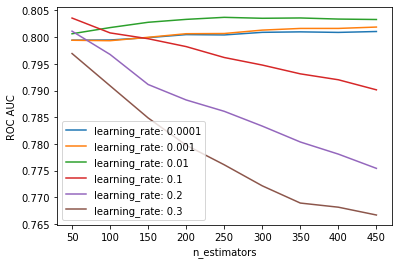

Best model: roc_auc = 0.803714 using {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__n_estimators': 250, 'model__subsample': 0.8}

In [ ]:
# Step 1: Searching for the optimum parameters for the learning rate and the number of estimators:

# Defining the parameter grid to be used in GridSearch:
param_grid = {"model__subsample": [0.8], "model__colsample_bytree": [0.8]
              , "model__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
              , "model__n_estimators": range(50,500,50)
              }

#instantiate the Grid Search:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7) 
grid_cv1 = GridSearchCV(xgb_pipeline
                        , param_grid
                        , n_jobs= -1 
                        , cv = cv
                        , scoring="roc_auc") 

# Fit
_ = grid_cv1.fit(X_train, y_train) 

# Checking the results from each run in the gridsearch:  
print_results_gridsearch(gridsearch=grid_cv1, list_param1 = param_grid["model__learning_rate"], list_param2 = param_grid["model__n_estimators"]
                         , name_param1 = 'learning_rate' , name_param2 = 'n_estimators')

So, with only changing the number of estimators and the learning rate, Aki already improves the ROC AUC score from 0.7915 to 0.8037 compared to Meta’s XGBoost with default settings.

Next up, with the best values identified for the number of estimators and the learning rate, Aki continues with optimizing the parameters: max_depth and min_child_weight.
- **Max_depth:** the maximum depth of a tree. It is used to control for overfitting. Increasing this value will make the model more complex, allowing the model to learn relations very specific to the sample at hand and making it more likely to overfit. In addition, XGBoost aggressively consumes memory when training a deep tree. Typically used values are 3–10 and as its default value is 6.
- **Min_child_weight:** the minimum sum of weights of all observations needed in a child node. So, if the tree partition step results in a leaf node with the sum of instance weight less than the min_child_weight, the building process will give up further partitioning. This parameter is also used to control for overfitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. But, too high values can lead to underfitting. Hence, it should be tuned using CV. The min_child_weight can be any number and the default is 1.

The results from each run in the gridsearch:
roc_auc = 0.797348 (0.004734) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.797315 (0.004521) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 3, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.797427 (0.004635) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.803552 (0.004558) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.802981 (0.004643) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.802122 (0.004717) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 5, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.802868 (0.004626) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.802325 (0.005165) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__min_child_weight': 3, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.801495 (0.004944) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__min_child_weight': 5, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.800782 (0.005170) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 9, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.800710 (0.005476) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 9, 'model__min_child_weight': 3, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.799786 (0.005152) with: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 9, 'model__min_child_weight': 5, 'model__n_estimators': 250, 'model__subsample': 0.8}

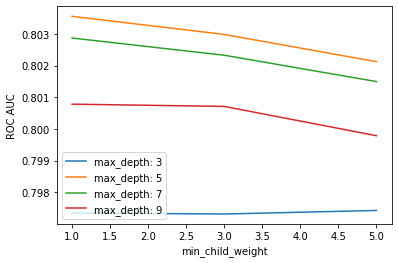

Best model: roc_auc = 0.803552 using {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.8}

In [ ]:
# Step 2: Searching for the optimum parameters for max_depth and min_child_weight:

# Defining the parameter grid to be used in GridSearch:
param_grid = {"model__subsample": [0.8], "model__colsample_bytree": [0.8], "model__learning_rate": [0.01], "model__n_estimators": [250]
              , 'model__max_depth': range(3,10,2)
              , 'model__min_child_weight': range(1,6,2)
             }

#instantiate the Grid Search:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_cv2 = GridSearchCV(xgb_pipeline
                        , param_grid
                        , n_jobs=-1
                        , cv=cv
                        , scoring="roc_auc") 

# Fit
_ = grid_cv2.fit(X_train, y_train) 

# Checking the results from each run in the gridsearch:  
print_results_gridsearch(gridsearch=grid_cv2, list_param1 = param_grid["model__max_depth"], list_param2 = param_grid["model__min_child_weight"]
                         , name_param1 = 'max_depth' , name_param2 = 'min_child_weight')


The search for optimal values for the maximum depth of a tree and the minimum child weight resulted in only changing the maximum depth from six to five and keeping the minimum child weight at the default of 1. Due to only a small change to the parameters, the performance of the new best performing model is comparable to the previous one. The mean ROC AUC from the cross validation in this gridsearch is even slightly lower, it decreased from 0.8037 to 0.8036.

Third, Aki tries to improve the parameters: subsample and colsample_bytree.
- **Subsample:** the fraction of observations XGBoost will randomly take for constructing each tree. If you set this value to 0.5, XGBoost will randomly collect half of the records to grow trees. This can be used to prevent overfitting. A lower value prevents overfitting and makes the algorithm more conservative, but too small values might lead to underfitting. Typically used values are 0.4–1 and its default value is 1.
- **Colsample_bytree:** the fraction of columns XGBoost will randomly take for constructing each tree. This parameter can also be used to control for overfitting. Typically used values are 0.4–1 and as its default value is 1.

The results from each run in the gridsearch:
roc_auc = 0.801835 (0.004100) with: {'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.4}
roc_auc = 0.801859 (0.004040) with: {'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.5}
roc_auc = 0.801711 (0.004474) with: {'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.6}
roc_auc = 0.802227 (0.004116) with: {'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.7}
roc_auc = 0.802185 (0.004200) with: {'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.801890 (0.004620) with: {'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.9}
roc_auc = 0.802568 (0.004090) with: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.4}
roc_auc = 0.802250 (0.004149) with: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.5}
roc_auc = 0.802341 (0.003983) with: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.6}
roc_auc = 0.802240 (0.003797) with: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.7}
roc_auc = 0.802525 (0.004073) with: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.802336 (0.003879) with: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.9}
roc_auc = 0.803482 (0.004133) with: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.4}
roc_auc = 0.803173 (0.004504) with: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.5}
roc_auc = 0.802826 (0.004007) with: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.6}
roc_auc = 0.802763 (0.003893) with: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.7}
roc_auc = 0.803144 (0.004248) with: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.8}
roc_auc = 0.802890 (0.004136) with: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.9}
roc_auc = 0.803400 (0.004512) with: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.4}
roc_auc = 0.803332 (0.004373) with: {'model__colsample_bytre

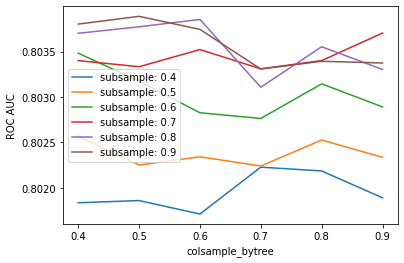

Best model: roc_auc = 0.803887 using {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__subsample': 0.5}

In [ ]:
# Step 3: Searching for the optimum parameters for subsample and colsample_bytree:

# Defining the parameter grid to be used in GridSearch:
param_grid = {"model__learning_rate": [0.01], "model__n_estimators": [250], 'model__max_depth': [5], 'model__min_child_weight': [1]
              , 'model__subsample':[i/10.0 for i in range(4,10)]
              , 'model__colsample_bytree':[i/10.0 for i in range(4,10)] 
             }

#instantiate the Grid Search:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_cv3 = GridSearchCV(xgb_pipeline
                        , param_grid
                        , n_jobs=-1
                        , cv=cv
                        , scoring="roc_auc") 

# Fit
_ = grid_cv3.fit(X_train, y_train) 

# Checking the results from each run in the gridsearch:  
print_results_gridsearch(gridsearch=grid_cv3, list_param1 = param_grid["model__subsample"], list_param2 = param_grid["model__colsample_bytree"]
                         , name_param1 = 'subsample' , name_param2 = 'colsample_bytree')

The grid search above resulted in the optimum values: 0.5 for the subsample and 0.9 for the colsample_bytree. In other words, the grid search shows that the best model performance is achieved by constructing each tree based on half of the records and 90% of the features. Tuning these parameters improve the model performance from an AUC ROC score of 0.8036 to 0.8039.

Finally, Aki tries to improve the model even further by tuning the gamma and the lambda.
- **Gamma (min_split_loss):** specifies the minimum loss reduction required to make a split. A node only splits when the resulting split gives a positive reduction in the loss function above the gamma threshold. It is a pseudo-regularization hyperparameter in gradient boosting. The higher the Gamma, the higher the regularization, and the more conservative the algorithm. Gamma depends on both the training set and the other parameters you use. Gamma can be any integer and its default value is 0.
- **Lambda:** the L2 regularization term on weights (analogous to Ridge regression). This term is a constant that is added to the second derivative (Hessian) of the loss function during gain and weight (prediction) calculations. Lambda effects the choice of split points as well as the weight size. Although many data scientist don’t tune this parameter, it should be explored to reduce overfitting. Increasing this value will make the model more conservative. Lambda can be any integer and its default value is 1. XGBoost is also known as a ‘regularized boosting’ technique, due to its regularization terms.

The results from each run in the gridsearch:
roc_auc = 0.803624 (0.004730) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 0, 'model__subsample': 0.5}
roc_auc = 0.803668 (0.004591) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 0.5, 'model__subsample': 0.5}
roc_auc = 0.803887 (0.004703) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 1, 'model__subsample': 0.5}
roc_auc = 0.803723 (0.004520) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 1.5, 'model__subsample': 0.5}
roc_auc = 0.803611 (0.004193) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 2, 'model__subsample': 0.5}
roc_auc = 0.803493 (0.004481) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 3, 'model__subsample': 0.5}
roc_auc = 0.803323 (0.004929) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 4.5, 'model__subsample': 0.5}
roc_auc = 0.803601 (0.004751) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 0, 'model__subsample': 0.5}
roc_auc = 0.803698 (0.004611) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 0.5, 'model__subsample': 0.5}
roc_auc = 0.803857 (0.004741) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 1, 'model__subsample': 0.5}
roc_auc = 0.803733 (0.004557) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 1.5, 'model__subsample': 0.5}
roc_auc = 0.803648 (0.004199) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 2, 'model__subsample': 0.5}
roc_auc = 0.803501 (0.004445) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 3, 'model__subsample': 0.5}
roc_auc = 0.803320 (0.004882) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 4.5, 'model__subsample': 0.5}
roc_auc = 0.803580 (0.004764) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.2, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 0, 'model__subsample': 0.5}
roc_auc = 0.803669 (0.004559) with: {'model__colsample_bytree': 0.9, 'model__gamma': 0.2, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators

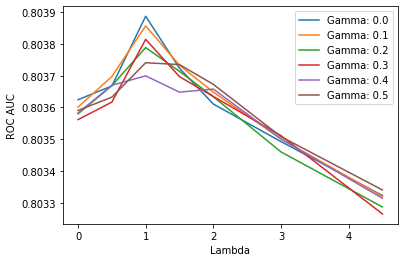

Best model: roc_auc = 0.803887 using {'model__colsample_bytree': 0.9, 'model__gamma': 0.0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__reg_lambda': 1, 'model__subsample': 0.5}

In [ ]:
# Step 4: Searching for the optimum parameters for gamma and lambda: 

# Defining the parameter grid to be used in GridSearch:
param_grid = {"model__learning_rate": [0.01], "model__n_estimators": [250], 'model__max_depth': [5], 'model__min_child_weight': [1], 'model__subsample':[0.5], 'model__colsample_bytree':[0.9] 
              , "model__gamma": [i/10.0 for i in range(0,6)]
              , "model__reg_lambda": [0, 0.5, 1, 1.5, 2, 3, 4.5]
             }
              
#instantiate the Grid Search:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_cv4 = GridSearchCV(xgb_pipeline
                        , param_grid
                        , n_jobs=-1
                        , cv=cv
                        , scoring="roc_auc") 


# Fit
_ = grid_cv4.fit(X_train, y_train) 

# Checking the results from each run in the gridsearch:  
print_results_gridsearch(gridsearch=grid_cv4, list_param1 = param_grid["model__gamma"], list_param2 = param_grid["model__reg_lambda"]
                         , name_param1 = 'Gamma' , name_param2 = 'Lambda')

This final grid search shows that the default values should not be changed. Therefore, Aki keeps Gamma equal to 0 and Lamda equal to 1, resulting in the same and final AUC ROC score of 0.8039. By tuning the model in four steps and searching for the optimal values for eight different hyperparameters, Aki manages to improve Meta’s default XGBoost from a ROC AUC score of 0.791519 to 0.8039. This results in the best set of hyperparameters, which are shown below.

In [ ]:
grid_cv4.best_params_

Out[13]: {'model__colsample_bytree': 0.9,
 'model__gamma': 0.0,
 'model__learning_rate': 0.01,
 'model__max_depth': 5,
 'model__min_child_weight': 1,
 'model__n_estimators': 250,
 'model__reg_lambda': 1,
 'model__subsample': 0.5}

Now both Meta and Aki found their final parameters for their XGBoost algorithms we can evaluate their models on the testset:

In [ ]:
# Predict with Aki's final XGBoost with the best parameters resulting from the GridSearch: 
y_pred_aki = grid_cv4.predict(X_test)
y_pred_prob_aki = grid_cv4.predict_proba(X_test)[::,1]

# Evaluate:
print("roc_auc_score:",metrics.roc_auc_score(y_test, y_pred_aki))

roc_auc_score: 0.7149328865312845

In [ ]:
# Fit Meta's default XGBoost pipeline:
xgb_pipeline.fit(X_train, y_train)

# Predict:
y_pred_meta = xgb_pipeline.predict(X_test)
y_pred_prob_meta = xgb_pipeline.predict_proba(X_test)[::,1]

# Evaluate:
print("roc_auc_score:",metrics.roc_auc_score(y_test, y_pred_meta))

roc_auc_score: 0.6993045967695355

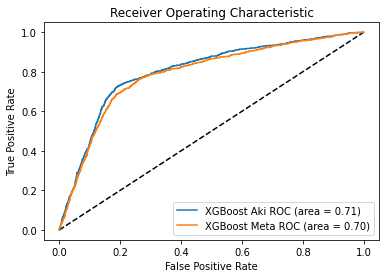

In [ ]:
# Compute False postive rate, and True positive rate
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob_aki)
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob_meta)

# Calculate Area under the curve to display on the plot
roc_auc_aki = metrics.roc_auc_score(y_test, y_pred_aki)
roc_auc_meta = metrics.roc_auc_score(y_test, y_pred_meta)

# Now, plot the computed values
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= '%s ROC (area = %0.2f)' % ("XGBoost Aki", roc_auc_aki)) #"XGBoost Aki")
plt.plot(fpr2, tpr2, label= '%s ROC (area = %0.2f)' % ("XGBoost Meta", roc_auc_meta)) #label= "XGBoost Meta")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

As on the trainset, Aki’s tuned XGBoost outperforms Meta’s default XGBoost. Aki’s tuning resulted in an improved ROC AUC score of 0.7149 compared to Meta’s ROC AUC score of 0.6993. As we did for Meta in the previous article, we also save Aki’s model to be able to compare results later on. Just to be sure, we quickly test if her model is saved correctly.

In [ ]:
#Saving Aki's final XGBoost pipeline:
best_pipe_aki = grid_cv4.best_estimator_
joblib.dump(best_pipe_aki, 'best_pipe_aki.joblib')

Out[24]: ['best_pipe_aki.joblib']

In [ ]:
#Testing if Aki's model is correctly saved:

# Load the models:  
upload_pipe_aki = joblib.load('best_pipe_aki.joblib')

# Use it to make the same predictions:
print(upload_pipe_aki.predict(X_test))

[0 1 0 ... 0 1 0]

I hope you enjoyed reading this article and getting to know Aki. Her approach didn’t really focus on prepping the features, she focused on improving Meta’s XGBoost by tuning the hyperparameters. In the upcoming articles we investigate if we can improve her data preparations. Topics that we will look into are <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-beat-dirty-data" target="_blank" rel="noopener noreferrer">common data problems</a>, <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-the-case-of-high-cardinality-kerfuffles" target="_blank" rel="noopener noreferrer">dealing with high cardinality</a>, and <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-guide-to-manage-missing-data" target="_blank" rel="noopener noreferrer">dealing with missing data</a>. We will not only focus on improving model performance, but also how to improve the interpretability and explainability of the models. This is something both Andy Stand and Eqaan Librium value very much when practicing data science.

Overview of links to blogs:
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-introducing-our-data-science-rock-stars" target="_blank" rel="noopener noreferrer">Introducing our data science rock stars</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-data-to-predict-which-employees-are-likely-to-leave" target="_blank" rel="noopener noreferrer">Data to predict which employees are likely to leave</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-good-model-by-default-using-xgboost" target="_blank" rel="noopener noreferrer">Good model by default using XGBoost</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-hyperparameter-tuning-for-hyperaccurate-xgboost-model" target="_blank" rel="noopener noreferrer">Hyperparameter tuning for hyperaccurate XGBoost model</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-beat-dirty-data" target="_blank" rel="noopener noreferrer">Beat dirty data</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-the-case-of-high-cardinality-kerfuffles" target="_blank" rel="noopener noreferrer">The case of high cardinality kerfuffles</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-guide-to-manage-missing-data" target="_blank" rel="noopener noreferrer">Guide to manage missing data</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-visualise-the-business-value-of-predictive-models" target="_blank" rel="noopener noreferrer">Visualise the business value of predictive models</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same" target="_blank" rel="noopener noreferrer">No data scientist is the same!</a>